# Author: René Uhliar

### Data set used in this notebook has been obtained from Kaggle.
### Link to data set: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

This notebook contains additional tasks I've free willingy performed to prove the skills I obtained during the data science minor.

The data consists of image data containing images of infected by Malaria, and uninfected wounds.

## Data preparation

In [1]:
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import random

# Configure GPU usage
os.environ["CUDA_VISIBLE_DEVICES"]="2"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Directories with data for this task
base_dir = "/home/14036738/notebooks/cell_images/"
unprocessed_imgs_base_dir = base_dir + "images/"
infected_imgs_dir = unprocessed_imgs_base_dir + "parasitized/"
uninfected_imgs_dir = unprocessed_imgs_base_dir + "uninfected/"
all_imgs_dir = base_dir + "all/"
all_infected_dir = all_imgs_dir + "parasitized/"
all_uninfected_dir = all_imgs_dir + "uninfected/"
val_imgs_dir = base_dir + "validation/"
val_infected_dir = val_imgs_dir + "parasitized/"
val_uninfected_dir = val_imgs_dir + "uninfected/"
test_imgs_dir = base_dir + "test/"
test_infected_dir = test_imgs_dir + "parasitized/"
test_uninfected_dir = test_imgs_dir + "uninfected/"

Using TensorFlow backend.
/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We copy all unprocessed parasitized and uninfected images to the all images directory into the appropriate folder. This is done, because when later using `ImageDataGenerator#flow_from_directory` functions, these functions require the files to be stored in their appropriate folder. For each folder, a class will be created (this can be seen in the output of a cell later on).

So to clarify, in this case we will have 2 classes. The parasitized and the uninfected ones.

In [9]:
# Labels to be appended to the start of each file to later on distinguish between parasitized and uninfected
# when appending to a list containing all images.
uninfected_label = "0_"
parasitized_label = "1_"

# Copy yet unprocessed infected images to ~/notebooks/cell_images/all/infected/
for file in os.listdir(infected_imgs_dir):
    if ".png" in file:
        shutil.copyfile(os.path.join(infected_imgs_dir, file), all_infected_dir + parasitized_label + file)

# Copy yet unprocessed uninfected images to ~/notebooks/cell_images/all/uninfected/
for file in os.listdir(uninfected_imgs_dir):
    if ".png" in file:
        shutil.copyfile(os.path.join(uninfected_imgs_dir, file), all_uninfected_dir + uninfected_label +file)

Get all parasitized and uninfected images into a list, so that we can extract a certain amount of these for the validation set later on.

In [2]:
all_imgs = []
for file in os.listdir(all_infected_dir):
    if ".png" in file and os.path.isfile(os.path.join(all_infected_dir, file)):
        all_imgs.append(file)
        
for file in os.listdir(all_uninfected_dir):
    if ".png" in file and os.path.isfile(os.path.join(all_uninfected_dir, file)):
        all_imgs.append(file)

Extract 10% test and 20% validation random parasitized and uninfected images from the `all_imgs` list set. Based on the previously set labels "0_" and "1_", we extract the correct image (parasitized or uninfected) and move it to the appropriate test folder.

E.g. We extract the file 1_C208ThinF_IMG_20151029_155411_cell_8.png. We move this file to the ~/notebooks/cell_images/test/parasitized/ folder, because the label "1_" at the start of the file states that the image contains a parasitized wound.

In [4]:
test_amount = 2756 # 27558 * 0.1 = 2756
validation_amount = 5512 # 27558 * 0.2 = 5512

def move_random_files_to_val_test_folders(amount_of_random_data, all_imgs_list, infected_dir, uninfected_dir):
    for i in range(amount_of_random_data):
        file = random.choice(all_imgs_list)
        if file.startswith("1_"):
            shutil.move(os.path.join(all_infected_dir, file), infected_dir)
        else:
            shutil.move(os.path.join(all_uninfected_dir, file), uninfected_dir)

        # Remove the file from the list, else it might be chosen twice which will throw a duplicate error.
        all_imgs_list.remove(file)
        
move_random_files_to_val_test_folders(test_amount, all_imgs, test_infected_dir, test_uninfected_dir)
move_random_files_to_val_test_folders(validation_amount, all_imgs, val_infected_dir, val_uninfected_dir)

## Data visualization

This function will get the false and true (0 and 1) classes as arguments and will be plotted as a histogram to see the difference, in samples in this case, between the two classes.

In [26]:
def plot_classes(zero, one):
    print("Amount of infected: " + str(len(one)))
    print("Amount of uninfected: "+ str(len(zero)))
    plt.hist([zero, one], bins=1, color=['orange', 'blue'])
    plt.ylabel('Amount of samples')
    plt.legend(['uninfected', 'infected'])
    plt.show()

Here we can see the total amount of infected and uninfected training set images. There are total of ~27k images, but there are less than 10k images per class, because files have already been split for validation and testing as well.

Amount of infected: 9676
Amount of uninfected: 9614


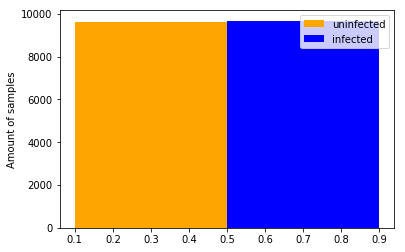

In [27]:
amt_of_uninfected = []
amt_of_infected = []

for file in all_imgs:
    if file.startswith(parasitized_label):
        amt_of_infected.append(1)
    else:
        amt_of_uninfected.append(0)

plot_classes(amt_of_uninfected, amt_of_infected)

## Building / training a predictive model

Create the ImageDataGeneratores for the later initialization of train and test generators.
https://keras.io/preprocessing/image/

In [19]:
from keras.preprocessing import image

train_data = image.ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_data = image.ImageDataGenerator(rescale=1. / 255)

Extract the train data from the `all_imgs_dir` and validation data from `val_imgs_dir` which will be used for training the model. The folders in these 2 base folders are the classes (parasitized and uninfected). So `train_generator` and `validation_generator` both have 2 classes each, both containing the images that belong to these 2 classes.

In [20]:
train_generator = train_data.flow_from_directory(all_imgs_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
validation_generator = validation_data.flow_from_directory(val_imgs_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


Build the Convolutional Neural Network, with multiple convolutional, pooling and dense input/output layers. We also add a dropout layer to make the neurons remmber less and thus make the model less overfit.

In [22]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Diagnostics of the learning process

Train the model. The provided arguments are adjusted by earlier trial and error to be set to the best found performance.

In [24]:
result = model.fit_generator(train_generator, steps_per_epoch=400, epochs=30, validation_data=validation_generator, validation_steps=100)

Epoch 1/30
400/400 [==============================] - 41s - loss: 0.6482 - acc: 0.6395 - val_loss: 0.4824 - val_acc: 0.8356
Epoch 2/30
400/400 [==============================] - 40s - loss: 0.3657 - acc: 0.8741 - val_loss: 0.2788 - val_acc: 0.9276
Epoch 3/30
400/400 [==============================] - 40s - loss: 0.2760 - acc: 0.9087 - val_loss: 0.2403 - val_acc: 0.9287
Epoch 4/30
400/400 [==============================] - 40s - loss: 0.2275 - acc: 0.9238 - val_loss: 0.2507 - val_acc: 0.9285
Epoch 5/30
400/400 [==============================] - 40s - loss: 0.2306 - acc: 0.9271 - val_loss: 0.2084 - val_acc: 0.9406
Epoch 6/30
400/400 [==============================] - 40s - loss: 0.2222 - acc: 0.9239 - val_loss: 0.2402 - val_acc: 0.9292
Epoch 7/30
400/400 [==============================] - 40s - loss: 0.2177 - acc: 0.9274 - val_loss: 0.1920 - val_acc: 0.9386
Epoch 8/30
400/400 [==============================] - 39s - loss: 0.2036 - acc: 0.9332 - val_loss: 0.2008 - val_acc: 0.9366
Epoch 9/

Here we plot the model diagnostics (accuracy and loss plots). The code is based on https://keras.io/visualization/#training-history-visualization but has been slightly adjusted to display everything correctly.

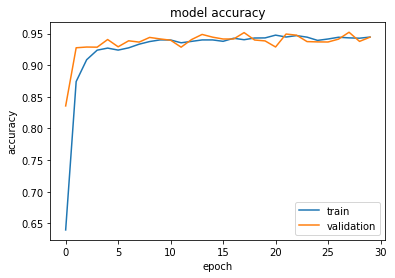

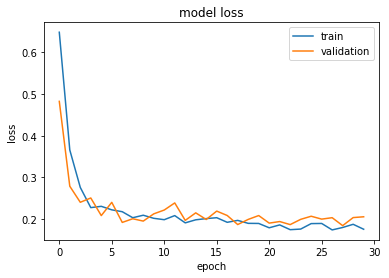

In [38]:
# summarize history for accuracy
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Trained model evaluation

In [37]:
# [loss, accuracy]
result.model.evaluate_generator(generator=validation_generator, steps=20)

[0.18157183965668083, 0.946875]

## Using predictive model

Here we can see how the generator extracted the labels based on the folder names:
### generator parasitized label = 0
### generator uninfected label = 1

In [27]:
train_generator.class_indices

{'parasitized': 0, 'uninfected': 1}

Collect all test images into one list which will be used for prediction on unseen data. We also use Keras `image` and Numpy `np` to process each image in such a format that is acceptable by our `model#predict` function in a later ipynb cell.

In [29]:
test_images = []

def append_dir_images_to_list(the_list, directory):
    for file in os.listdir(directory):
        if ".png" in file:
            img_file = image.load_img(os.path.join(directory, file), target_size=(150, 150))
            img_file = image.img_to_array(img_file)
            img_file = np.expand_dims(img_file, axis=0)
            test_images.append(img_file)

append_dir_images_to_list(test_images, test_infected_dir)
append_dir_images_to_list(test_images, test_uninfected_dir)

Predict on unseen (test) data. We append every prediction result into a list, which we'll later use to calculate correct / incorrect predictions.

In [30]:
predictions = []
for image_arr in test_images:
    predicted = result.model.predict(image_arr)
    predictions.append(predicted)
    

Final cell where we look at the amount of predicted versus the total amount of samples for each of the 2 classes.

In [31]:
# Extract the labels (0 or 1) from the predictions.
numbers = [int(x[0][0]) for x in predictions]
zero = 0
one = 0

# Count the amount of parasitized and the uninfected, increment the 'zero' and 'one' 
# variables for each corresponding label.
for number in numbers:
    if number == 0:
        # Remember: generator 0 = parasitized, so our 1 (one) increases
        one += 1
    elif number == 1:
        # Remember: generator 1 = uninfected, so our 0 (zero) increases
        zero += 1

"""
Obtains the total amount of png image content of a given directory.
"""
def count_images_in_dir(directory):
    return len(os.listdir(directory))

print("Total amount of test samples: " + str(len(numbers)))
print()
print("Total amount uninfected test samples: " + str(count_images_in_dir(test_uninfected_dir)))
print("Predicted amount uninfected samples: " + str(zero))
print()
print("Total amount parasitized test samples: " + str(count_images_in_dir(test_infected_dir)))
print("Predicted amount parasitized samples: " + str(one))

Total amount of test samples: 2756

Total amount uninfected test samples: 1347
Predicted amount uninfected samples: 1359

Total amount parasitized test samples: 1409
Predicted amount parasitized samples: 1397
